In [ ]:
!pip install xgboost

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import re
import string
from scipy import stats
from random import sample
from collections import Counter
from PIL import Image

# Plotting Libraries
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_theme(context="notebook", style="darkgrid", palette="pastel")


# NLP Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# stemming
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("portuguese")

# sklearn
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans

# torch
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# XGBoost
import xgboost as xgb



# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# Libraries for Sentiment Analysis
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')

**Set seed for random operations**

In [ ]:
seed = 42

In [ ]:
df1 = pd.read_csv('/content/petrobras.csv')
df2 = pd.read_csv('/content/petrobras2.csv')
df = pd.concat([df1, df2])
df.drop_duplicates(inplace=True)
# df = df[['text','date']]
df = df[['text','createdAt']]
df.columns = ['text', 'date']



In [ ]:
df.shape

(95, 2)

### **4.4. Analysis on Text Data**

#### **4.4.1 NLP on review comment messages**

No dataframe, podemos observar muitos dados de texto que podem ser valiosos para análise. Vamos dividir o conteúdo da coluna em uma lista de palavras e usaremos a biblioteca **nltk** para facilitar o processamento do texto.

Limpeza da coluna `text` para substituir valores vazios ou inválidos, como `NaN` para análise.

Podemos primeiro verificar o `info()` da coluna `text`:

In [ ]:
df[['text']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 95 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    95 non-null     object
dtypes: object(1)
memory usage: 1.5+ KB


Para poder analisar os tweets do bradesco, precisamos primeiro eliminar os valores NaN:

In [ ]:
text_dropna = df['text'].dropna()

Com os dados limpos podemos começar a usar a biblioteca `nltk` e avaliar o conteúdo do tweet.

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Import `stopwords` library
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('portuguese'))
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Construindo a função `tokenize_content` para tokenizar as frases de revisão para análise posterior.

In [ ]:
#Aqui eu defino um tokenizer e stemming que retorne o conjunto de hastes no texto em que é passado
def tokenize_and_stem(text):
    # Primeiro tokenizo por frase, depois por palavra para garantir que a pontuação seja capturada como seu próprio token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filtro qualquer tokens que não contenha cartas (por exemplo, tokens numéricos, pontuação crua)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # Primeiro tokenize por frase, depois por palavra para garantir que a pontuação seja capturada como seu próprio token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filtre qualquer tokens que não contenha cartas (por exemplo, tokens numéricos, pontuação crua)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [ ]:

def clean_pt(text):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', str(text))

    # Convert text to lowercase
    text = text.lower()

    # Substituir algumas pontuações
    text = text.replace('é', 'e').replace('á', 'a').replace('í', 'i').replace('ó', 'o') \
               .replace('ú', 'u').replace('ã', 'a').replace('â', 'a').replace('ê', 'e') \
               .replace('ô', 'o').replace('õ', 'o').replace('ç', 'c')

    # Replace anything other than alphabets a-z with a space
    text = re.sub('[^a-z]', ' ', str(text))

    # Adiciona stopwords personalizadas
    stopwords_personalize = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'es', 'ar', 'ag']
    stopwords = stopwords.union(stopwords_personalize)

    # Split the text into single words
    words = text.split()

    # Remove stopwords
    top_tokens_no_stopwords = [word for word in words if word not in stopwords]

    # Join words back into a single string
    cleaned_text = top_tokens_no_stopwords

    return cleaned_text


In [ ]:
def clean(text):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', str(text))

    # Convert text to lowercase
    text = text.lower()

    #Algumas pontuações para remover
    substituicoes = {
    'é': 'e',
    'á': 'a',
    'í': 'i',
    'ó': 'o',
    'ú': 'u',
    'ã': 'a',
    'â': 'a',
    'ê': 'e',
    'ô': 'o',
    'õ': 'o',
    'ç': 'c'}
    # text = text.replace(substituicoes)
    text = text.replace('é', 'e').replace('á', 'a').replace('í', 'i').replace('ó', 'o') \
							.replace('ú', 'u').replace('ã', 'a').replace('â', 'a').replace('ê', 'e') \
							.replace('ô', 'o').replace('õ', 'o').replace('ç', 'c')
    # Replace anything other than alphabets a-z with a space
    text = re.sub('[^a-z]', ' ', text)

    # Split the text into single words
    text = text.split()

    # Initialize WordNetLemmatizer
    #lm = WordNetLemmatizer()

    # Lemmatize words and remove stopwords
    #text = [lm.lemmatize(word) for word in text if word not in set(
        #stopwords.words('english'))]

    # Join the words back into a sentence
    stopwords_personalize = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'es','ar', 'ag']
    stopwords = stopwords.union(stopwords_personalize)


    top_tokens_no_stopwords = [word for word in text if word not in stopwords]
    text = top_tokens_no_stopwords
    text = ' '.join(word for word in text)

    return text

In [ ]:
#Incrementando as Stopwords


In [ ]:

tweets = clean_pt(text_dropna.tolist())
top_tokens_list = []



# Crie top_tokens_list para todas as palavras nas avaliações
for tweet in tweets:
  token_words = tokenize_only(tweet)
  top_tokens_list.append(token_words)

top_tokens = [item for sublist in top_tokens_list for item in sublist]

Calculando a `top_most_common`  para mostrar as palavras que ocorrem mais vezes nos comentários da revisão.




In [ ]:
cnt = Counter()

# contando as ocorrencias das palavras
for word in top_tokens:
  cnt[word] += 1

top_most_common = sorted(cnt.items(), key=lambda item: -item[1])[:100]

Para visualizar os resultados, utilizamos o wordcloud para mostrar as frequências das palavras.

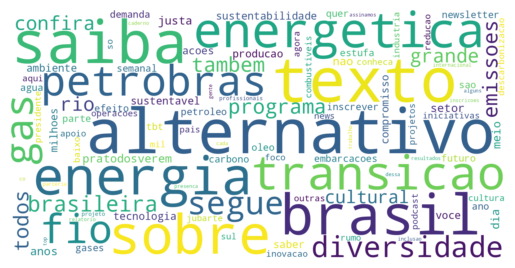

In [ ]:
freq_dict = {}



# criando um com as palavras mais comuns
for i in top_most_common:
  # Ignore a palavra se ela estiver em stopwords em inglês
  freq_dict[i[0]] = i[1]



wc = WordCloud(background_color='white', stopwords=stopwords,
               width=1600, height=800,
               max_words=100, max_font_size=200,
                          colormap="viridis")
wc.generate_from_frequencies(freq_dict)




plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Since the messages are in spanish, in the followings steops, we translated the `top_most_common` to English and create a corresponding word cloud in English for better reading.

Na nuvem de palavras acima, imprimimos palavras com base nas frequências que aparecem nas mensagens dos comentários da revisão. As palavras que possuem tamanhos maiores na nuvem de palavras indicam que são mais mencionadas nas mensagens, o que implica que são propriedades nas quais a maioria dos revisores se concentra. Essas informações podem nos fornecer os rumos de nossa pesquisa em que as palavras mais mencionadas nas avaliações podem ser os fatores que mais afetam as pontuações do ranking.

Podemos facilmente descobrir que a palavra “salário” teve um papel importante nas análises, apesar de existir outras palavras com maior frequêcia o contexto da palavra sálário tras uma melhor analise. É bem provavel que haja algum problema com o salário de clientes que usaram o Twitter para serem notados pela empresa. Porém, embora a palavra 'Salário' esteja entre ps primeiros lugares da lista, ela pode ser utilizada para comentar outras coisas, não necessáriamente uma reclamação. Para mostrar as avaliações com a palavra 'salário', pegamos uma amostra de 500 avaliações abaixo para mostrar como são as avaliações comentando sobre o sálario.



In [ ]:
sentences_with_salario = []
sample_tweets = sample(tweets, 100)
for tweet in sample_tweets:
  if 'salário' in tweet.lower():
    sentences_with_salario.append(tweet)
    break
print(sentences_with_salario)

A partir de todas as frases de avaliação, podemos observar que as avaliações provavelmente podem comentar sobre a qualidade do produto, seu processo de entrega ou produtos faltantes/errados, etc. É bastante ambíguo olhar apenas para a palavra 'produto' e vinculá-la diretamente ao qualidade dos produtos. Conseqüentemente, algumas outras palavras podem se tornar mais valiosas.

- **'recebido', 'chegou', 'entrega', 'prazo' etc.**

 Essas palavras têm uma classificação elevada no gráfico e todas são palavras relacionadas à entrega. Nos códigos a seguir, a porcentagem das frequências dessas palavras nas palavras `top_most_common` é calculada, o que mostra que na lista de tuplas `top_most_common`, esses termos relacionados à entrega ocuparam uma porção relativamente grande em todas as palavras comuns. Em outras palavras, a parte da entrega em todo o processo de pedido pode ser um grande fator que afeta a pontuação da classificação.

- **'bem', 'ótimo', 'super', 'nao', 'certo', 'Perfeito' etc.**

 Há também uma série de palavras que têm uma atitude forte associada a elas, que podem ser potencialmente utilizadas para análise de sentimento.